* [10.3.1. Non-hierarchical MCMC computation of each model’s marginal likelihood](#10.3.1.-Non-hierarchical-MCMC-computation-of-each-model’s-marginal-likelihood)
* [10.3.2. Hierarchical MCMC computation of relative model probability](#10.3.2.-Hierarchical-MCMC-computation-of-relative-model-probability)
* [10.3.2.1 Using pseudo-priors to reduce autocorrelation](#10.3.2.1-Using-pseudo-priors-to-reduce-autocorrelation)
* [Exercise 10.1](#Exercise-10.1)
* [Exercise 10.2](#Exercise-10.2)
* [Exercise 10.3](#Exercise-10.3)

## 10.3.1. Non-hierarchical MCMC computation of each model’s marginal likelihood

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns
import pystan as ps
import numpy as np

In [2]:
model_code = """
data {
    int N;    
    int y[N];
    real omega;
    real kappa;
}
parameters {
    real<lower=0,upper=1> theta;
}
model {
    real alpha;
    real beta;
    
    alpha = omega*(kappa-2) + 1;
    beta = (1-omega)*(kappa-2) + 1;
    
    for (i in 1:N) {
        y[i] ~ bernoulli(theta);
    }
    
    theta ~ beta(alpha, beta);
}
"""

Sample head-biased model

In [3]:
observations = np.repeat([0, 1], [3, 6])
N = len(observations)
omega = 0.75
# omega = 0.25
kappa = 12

data = {
    'N': N,
    'y': observations,
    'omega': omega,
    'kappa': kappa
}

fit = ps.stan(model_code=model_code, data=data, iter=11000, warmup=1000, chains=4)

In [4]:
samples = fit.extract(permuted=False, inc_warmup=False)
samples.shape

(10000, 4, 2)

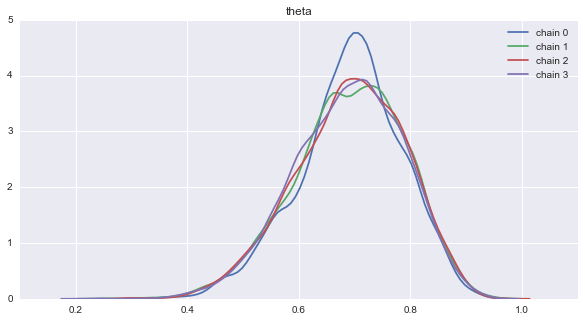

In [5]:
# Check MCMC conversion
f, ax = plt.subplots(1,1,figsize=(10,5))
for chain_id in range(samples.shape[1]):
    smpl = samples[:, chain_id, fit.flatnames.index('theta')]
    label = 'chain %d' % chain_id
    sns.kdeplot(smpl, label=label, ax=ax)
ax.set_title('theta')

plt.legend()
plt.show()

In [6]:
theta = fit['theta']

In [7]:
from scipy.stats import beta

In [8]:
# Compute mean and standard deviation of MCMC values:
theta_mean = theta.mean()
theta_std = theta.std()

# Convert to a,b shape parameters for use in h(theta) function:
post_a = theta_mean   * ( theta_mean*(1-theta_mean)/theta_std**2 - 1 )
post_b = (1-theta_mean) * ( theta_mean*(1-theta_mean)/theta_std**2 - 1 )
h = beta.pdf(theta, post_a, post_b)

In [9]:
N = len(observations)
z = observations.sum()
likelihood = theta**z * (1-theta)**(N-z)

In [10]:
prior_a = omega*(kappa-2)+1
prior_b = (1-omega)*(kappa-2)+1
prior = beta.pdf(theta, prior_a , prior_b)

In [11]:
prob_D_inv = (h / (likelihood*prior)).mean()
prob_D = 1/prob_D_inv
prob_D

0.0023378082939725991

In [12]:
prob_D1 = 0.0023318808086998967 # head-biased model
prob_D2 = 0.0004993362445442647 # tail-biased model

## 10.3.2. Hierarchical MCMC computation of relative model probability

Currently Stan does not support discrete variable. Switching to PyMC3

In [13]:
import pymc3 as pm
from theano import shared
from dbda2e_utils import plotPost

In [14]:
observations = np.repeat([0, 1], [3, 6])
z = observations.sum()
N = len(observations)
kappa = 12
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.1 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 118.2 sec

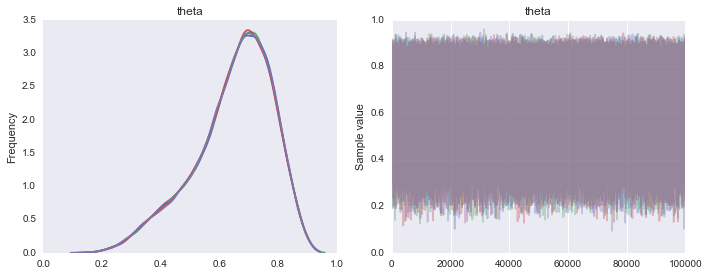

In [15]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta'])

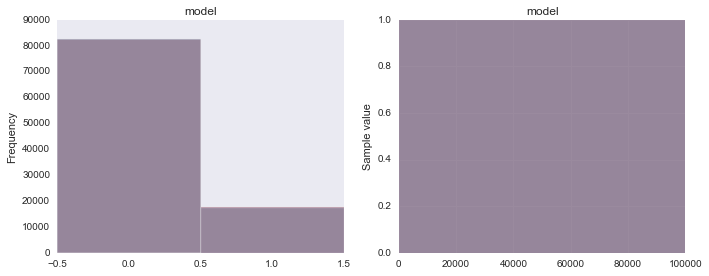

In [16]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['model'])

In [17]:
trace_df = pm.trace_to_dataframe(trace)

In [18]:
model0_mask = trace_df['model'] == 0
theta0 = trace_df[model0_mask]['theta'].values
theta1 = trace_df[~model0_mask]['theta'].values

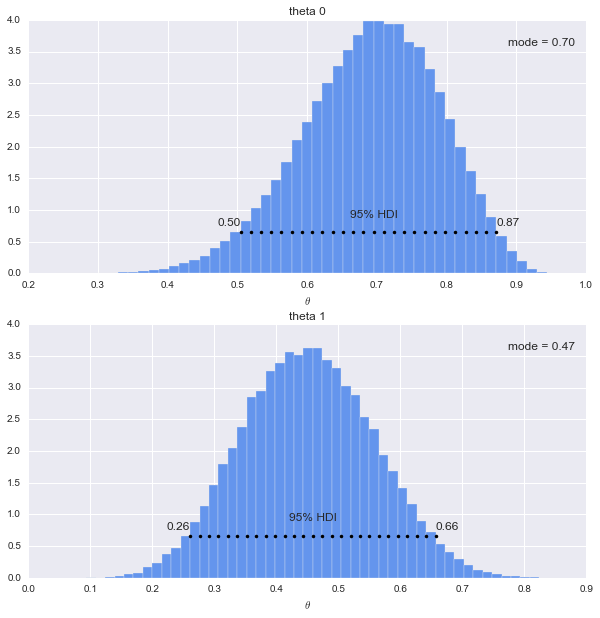

In [19]:
f, axs = plt.subplots(2,1,figsize=(10,10))
plotPost(theta0, ax=axs[0], title='theta 0')
plotPost(theta1, ax=axs[1], title='theta 1')

## 10.3.2.1 Using pseudo-priors to reduce autocorrelation

Using `switch` statement to combine models

In [20]:
observations = np.repeat([0, 1], [3, 6])
z = observations.sum()
N = len(observations)
kappa = 12
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    
    theta0 = pm.Beta('theta0', alpha[0], beta[0], transform=None) 
    theta1 = pm.Beta('theta1', alpha[1], beta[1], transform=None)
    
    theta = pm.switch(pm.eq(m, 0), theta0, theta1)
    theta = pm.Deterministic('theta', theta)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 1000 of 1000 complete in 1.4 secAssigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 100000 of 100000 complete in 138.8 sec

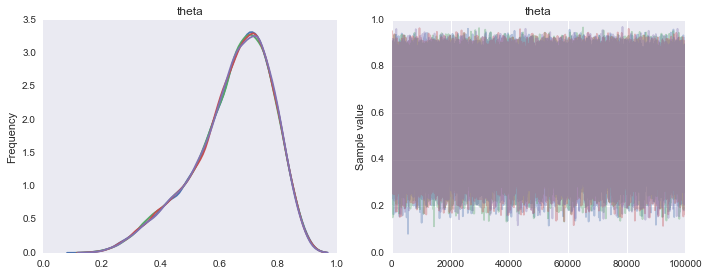

In [21]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta'])

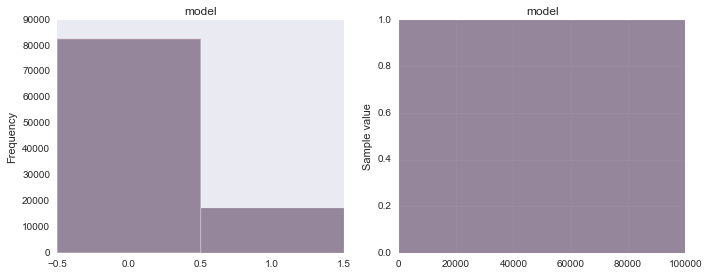

In [22]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['model'])

In [23]:
trace_df = pm.trace_to_dataframe(trace)

In [24]:
theta0 = trace_df['theta0'].values
theta1 = trace_df['theta1'].values

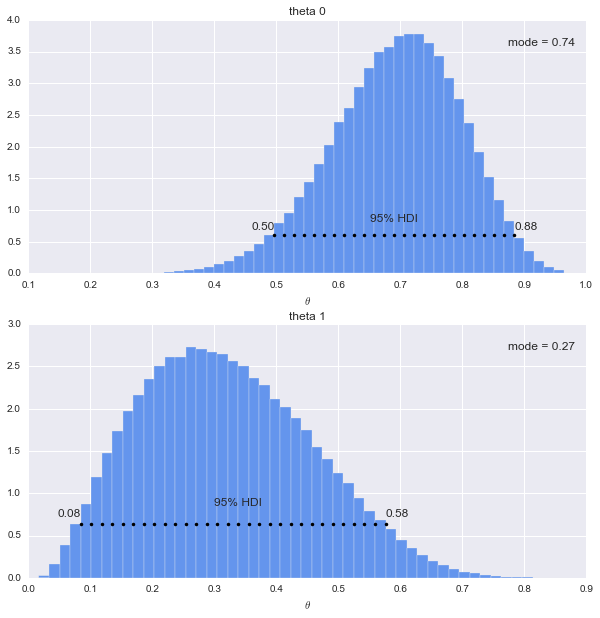

In [25]:
f, axs = plt.subplots(2,1,figsize=(10,10))
plotPost(theta0, ax=axs[0], title='theta 0')
plotPost(theta1, ax=axs[1], title='theta 1')

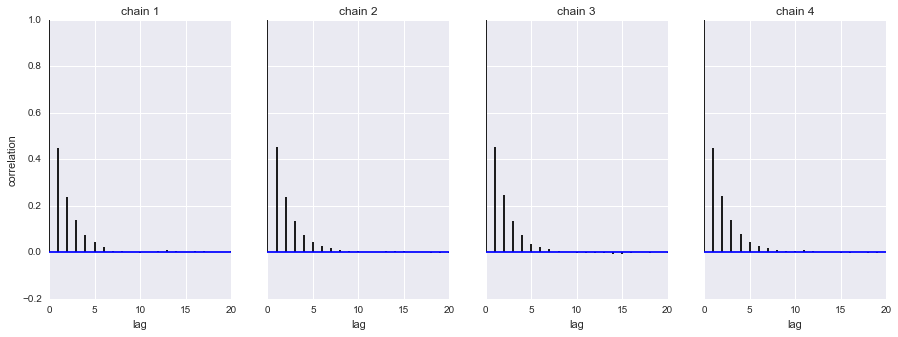

In [26]:
_ = pm.plots.autocorrplot(trace, max_lag=20, figsize=(15, 5), varnames=['model'])

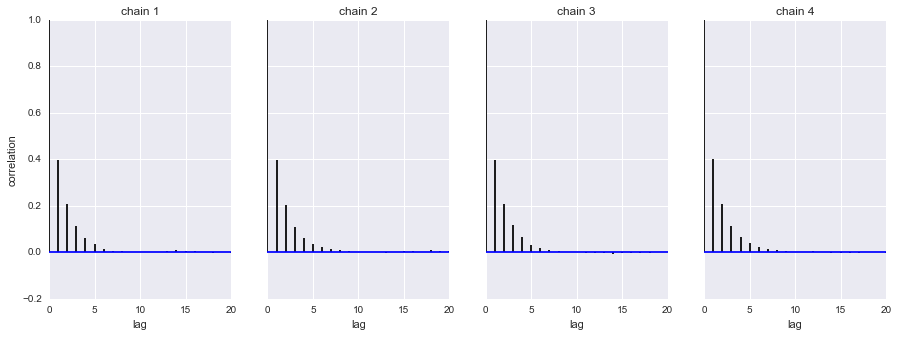

In [27]:
_ = pm.plots.autocorrplot(trace, max_lag=20, figsize=(15, 5), varnames=['theta1'])

Using pseudo priors

In [28]:
observations = np.repeat([0, 1], [13, 17])
z = observations.sum()
N = len(observations)

omega0 = np.array([0.10, 0.40]) # [true, pseudo] prior values
kappa0 = np.array([20, 50]) # [true, pseudo] prior values

omega1 = np.array([0.70, 0.90]) # [pseudo, true] prior value
kappa1 = np.array([50, 20]) # [pseudo, true] prior value

alpha0 = omega0*(kappa0-2) + 1
beta0 = (1-omega0)*(kappa0-2) + 1
# wrap into theano tensor
alpha0 = shared(alpha0, name='alpha0')
beta0 = shared(beta0, name='beta0')

alpha1 = omega1*(kappa1-2) + 1
beta1 = (1-omega1)*(kappa1-2) + 1
# wrap into theano tensor
alpha1 = shared(alpha1, name='alpha1')
beta1 = shared(beta1, name='beta1')

with pm.Model() as model:    
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    
    theta0 = pm.Beta('theta0', alpha0[m], beta0[m], transform=None) 
    theta1 = pm.Beta('theta1', alpha1[m], beta1[m], transform=None)
    
    theta = pm.switch(pm.eq(m, 0), theta0, theta1)
    theta = pm.Deterministic('theta', theta)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 1000 of 1000 complete in 2.6 secAssigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 100000 of 100000 complete in 275.8 sec

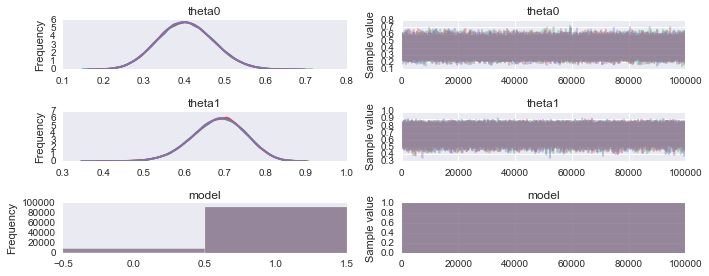

In [29]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta0', 'theta1', 'model'])

In [30]:
trace_df = pm.trace_to_dataframe(trace)

In [31]:
model0_mask = trace_df['model'] == 0
theta0_true = trace_df[model0_mask]['theta0'].values
theta0_pseu = trace_df[~model0_mask]['theta0'].values

model1_mask = trace_df['model'] == 1
theta1_true = trace_df[model1_mask]['theta1'].values
theta1_pseu = trace_df[~model1_mask]['theta1'].values

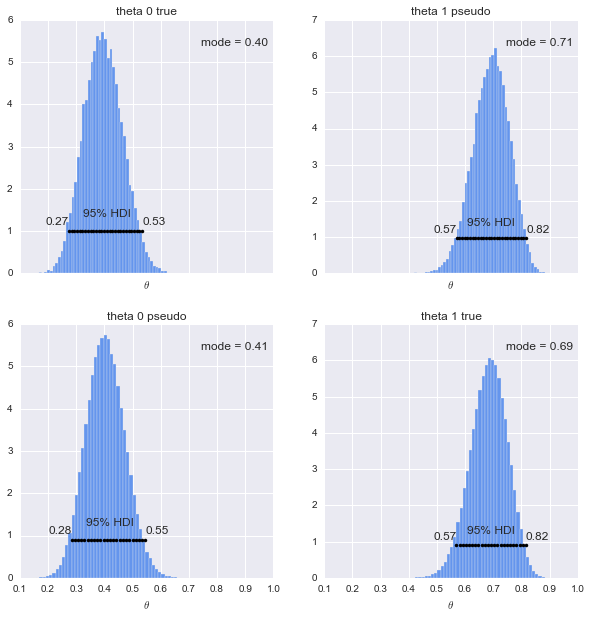

In [32]:
f, axs = plt.subplots(2,2,figsize=(10,10), sharex=True)
plotPost(theta0_true, ax=axs[0,0], title='theta 0 true')
plotPost(theta0_pseu, ax=axs[1,0], title='theta 0 pseudo')

plotPost(theta1_pseu, ax=axs[0,1], title='theta 1 pseudo')
plotPost(theta1_true, ax=axs[1,1], title='theta 1 true')


In [34]:
model0_mask.sum() / (model1_mask.sum() + model0_mask.sum())

0.080460000000000004

## Exercise 10.1

**Purpose**: To illustrate the fact that models with more distinctive predictions can be more easily discriminated.

In [35]:
z = 7
N = 10

In [36]:
from scipy.special import betaln
def p_D(z, N, omega, kappa):
    alpha = omega*(kappa - 2) + 1
    beta = (1-omega)*(kappa - 2) + 1
    
    postr = betaln(alpha+z, beta+N-z)
    prior = betaln(alpha, beta)
    
    return np.exp(postr - prior)

### Part A

In [37]:
omega1 = 0.25
omega2 = 0.75
kappa = 6

p_d1 = p_D(z, N, omega1, kappa)
p_d2 = p_D(z, N, omega2, kappa)

BF = p_d1 / p_d2
prior1 = prior2 = 0.5
posterior_odds = BF * prior1 / prior2

p_m1 = posterior_odds / (1 + posterior_odds)
p_m2 = 1 - p_m1
BF, p_m1, p_m2

(0.33333333333333354, 0.25000000000000011, 0.74999999999999989)

### Part B

In [38]:
omega1 = 0.25
omega2 = 0.75
kappa = 202

p_d1 = p_D(z, N, omega1, kappa)
p_d2 = p_D(z, N, omega2, kappa)

BF = p_d1 / p_d2
prior1 = prior2 = 0.5
posterior_odds = BF * prior1 / prior2

p_m1 = posterior_odds / (1 + posterior_odds)
p_m2 = 1 - p_m1
BF, p_m1, p_m2

(0.016215959918446363, 0.015957198625130557, 0.98404280137486944)

## Exercise 10.2

**Purpose**: To be sure you really understand the JAGS program for Figure 10.4.

### Part A

In [39]:
z = 6
N = 9
kappa = 12
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    # z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.3 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 125.1 sec

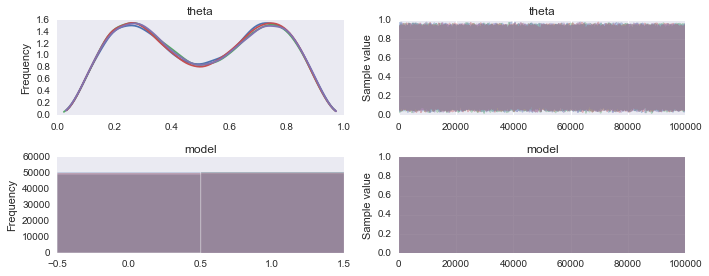

In [40]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta', 'model'])

In [41]:
trace_df = pm.trace_to_dataframe(trace)

In [42]:
model0_mask = trace_df['model'] == 0
theta0 = trace_df[model0_mask]['theta'].values
theta1 = trace_df[~model0_mask]['theta'].values

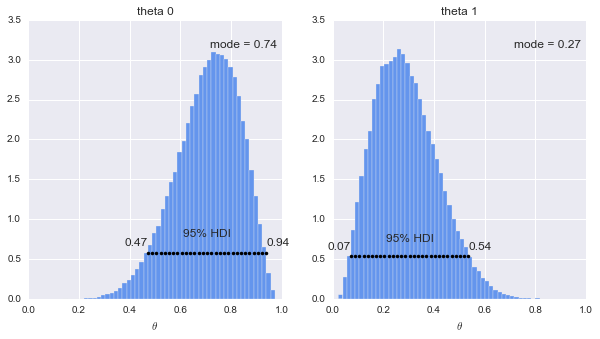

In [43]:
f, axs = plt.subplots(1,2,figsize=(10,5), sharex=True)
plotPost(theta0, ax=axs[0], title='theta 0')
plotPost(theta1, ax=axs[1], title='theta 1')

In [44]:
z = 6
N = 9
kappa = 12
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.1 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 117.9 sec

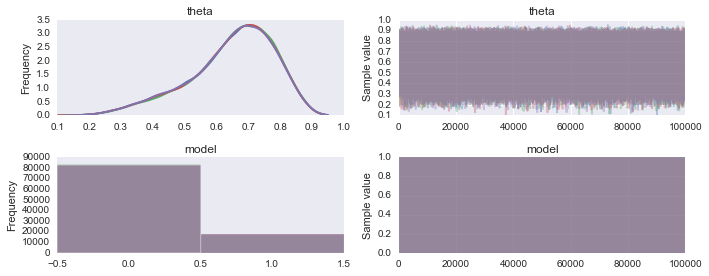

In [45]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta', 'model'])

In [46]:
trace_df = pm.trace_to_dataframe(trace)

In [47]:
model0_mask = trace_df['model'] == 0
theta0 = trace_df[model0_mask]['theta'].values
theta1 = trace_df[~model0_mask]['theta'].values

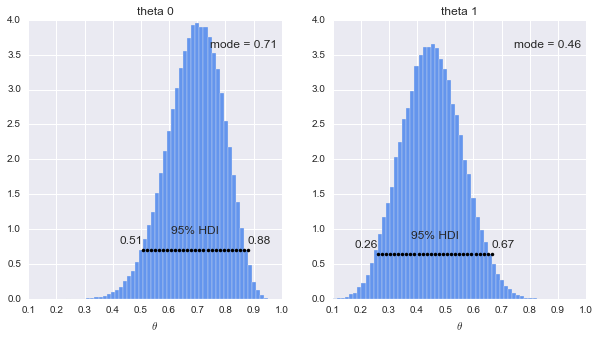

In [48]:
f, axs = plt.subplots(1,2,figsize=(10,5), sharex=True)
plotPost(theta0, ax=axs[0], title='theta 0')
plotPost(theta1, ax=axs[1], title='theta 1')

### Part B

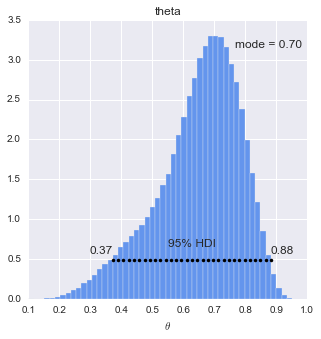

In [49]:
f, ax = plt.subplots(1,1,figsize=(5,5))
plotPost(trace_df['theta'].values, ax=ax, title='theta')

### Part C

**kappa = 6**

In [50]:
z = 7
N = 10
kappa = 6
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.2 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 124.2 sec

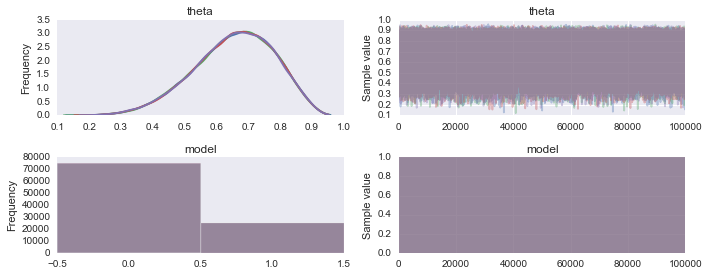

In [51]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta', 'model'])

In [52]:
trace_df = pm.trace_to_dataframe(trace)
counts = trace_df['model'].value_counts() / trace_df.shape[0]
counts

0    0.749595
1    0.250405
Name: model, dtype: float64

**kappa = 202**

In [53]:
z = 7
N = 10
kappa = 202
omega = np.array([0.75, 0.25])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.1 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 112.1 sec

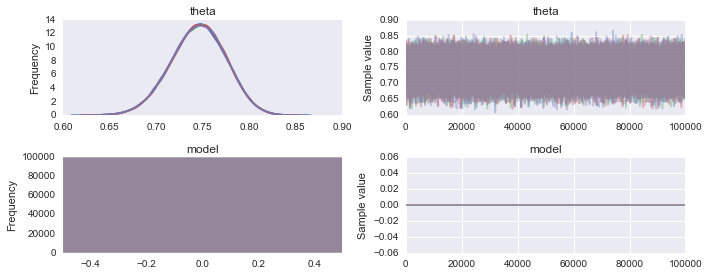

In [54]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta', 'model'])

In [55]:
trace_df = pm.trace_to_dataframe(trace)
counts = trace_df['model'].value_counts() / trace_df.shape[0]
counts

0    1.0
Name: model, dtype: float64

fix the model so it does not use the same model index

In [57]:
z = 7
N = 10
kappa = 52
omega = np.array([0.75, 0.25])
model_priors = np.array([0.05, 0.95])

with pm.Model() as model:    
    alpha = omega*(kappa-2) + 1
    beta = (1-omega)*(kappa-2) + 1
    # wrap into theano tensor
    alpha = shared(alpha, name='alpha')
    beta = shared(beta, name='beta')
        
    m = pm.Categorical('model', p=model_priors, transform=None)
    theta = pm.Beta('theta', alpha[m], beta[m], transform=None)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(100000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta
 [-----------------100%-----------------] 1000 of 1000 complete in 1.0 secAssigned NUTS to theta
 [-----------------100%-----------------] 100000 of 100000 complete in 118.5 sec

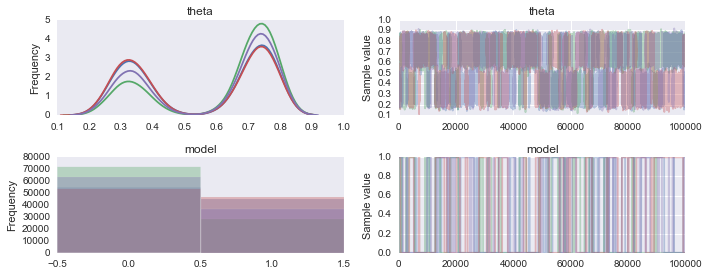

In [58]:
axs = pm.traceplot(trace, figsize=(10,4), varnames=['theta', 'model'])

In [96]:
trace_df = pm.trace_to_dataframe(trace)
counts = trace_df['model'].value_counts()
model_posteriors = counts / counts.sum()
model_posteriors

0    0.609842
1    0.390157
Name: model, dtype: float64

In [97]:
# renormalize model posteriors to 50/50 priors

model_posteriors[0] *= model_priors[1]
model_posteriors[1] *= model_priors[0]

In [98]:
model_posterior

0    0.967425
1    0.032575
Name: model, dtype: float64

## Exercise 10.3

**Purpose**: To get some hands-on experience with pseudo-priors.

### Part A

See [10.3.2.1 Using pseudo-priors to reduce autocorrelation](#10.3.2.1-Using-pseudo-priors-to-reduce-autocorrelation) for reference

### Part B

In [104]:
N = 30
z = int(0.55 * N + 0.5) # +0.5 for ceiling

omega0 = np.array([0.10, 0.50]) # [true, pseudo] prior values
kappa0 = np.array([20, 2.1]) # [true, pseudo] prior values

omega1 = np.array([0.50, 0.90]) # [pseudo, true] prior value
kappa1 = np.array([2.1, 20]) # [pseudo, true] prior value

alpha0 = omega0*(kappa0-2) + 1
beta0 = (1-omega0)*(kappa0-2) + 1
# wrap into theano tensor
alpha0 = shared(alpha0, name='alpha0')
beta0 = shared(beta0, name='beta0')

alpha1 = omega1*(kappa1-2) + 1
beta1 = (1-omega1)*(kappa1-2) + 1
# wrap into theano tensor
alpha1 = shared(alpha1, name='alpha1')
beta1 = shared(beta1, name='beta1')

with pm.Model() as model:    
    m = pm.Categorical('model', p=np.array([0.5, 0.5]), transform=None)
    
    theta0 = pm.Beta('theta0', alpha0[m], beta0[m], transform=None) 
    theta1 = pm.Beta('theta1', alpha1[m], beta1[m], transform=None)
    
    theta = pm.switch(pm.eq(m, 0), theta0, theta1)
    theta = pm.Deterministic('theta', theta)
    
    z = pm.Binomial('z', n=N, p=theta, observed=z)
    
    step = pm.BinaryMetropolis([m])
    trace = pm.sample(1000, step=step, njobs=4) # burn in
    trace = pm.sample(10000, step=step, start=trace[-1], njobs=4)

Assigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 1001 of 1000 complete in 108.2 secAssigned NUTS to theta0
Assigned NUTS to theta1
 [-----------------100%-----------------] 10000 of 10000 complete in 845.8 sec

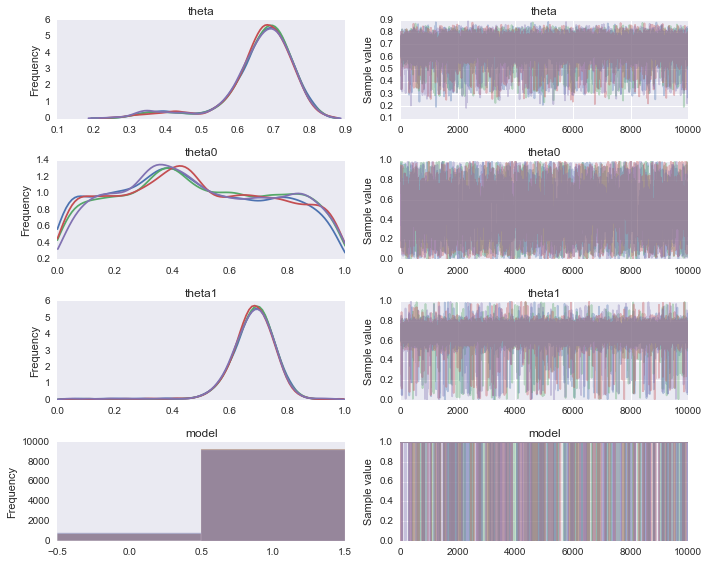

In [113]:
axs = pm.traceplot(trace, figsize=(10,8), varnames=[theta, 'theta0', 'theta1', 'model'])

In [106]:
trace_df = pm.trace_to_dataframe(trace)

In [107]:
model0_mask = trace_df['model'] == 0
theta0_true = trace_df[model0_mask]['theta0'].values
theta0_pseu = trace_df[~model0_mask]['theta0'].values

model1_mask = trace_df['model'] == 1
theta1_true = trace_df[model1_mask]['theta1'].values
theta1_pseu = trace_df[~model1_mask]['theta1'].values

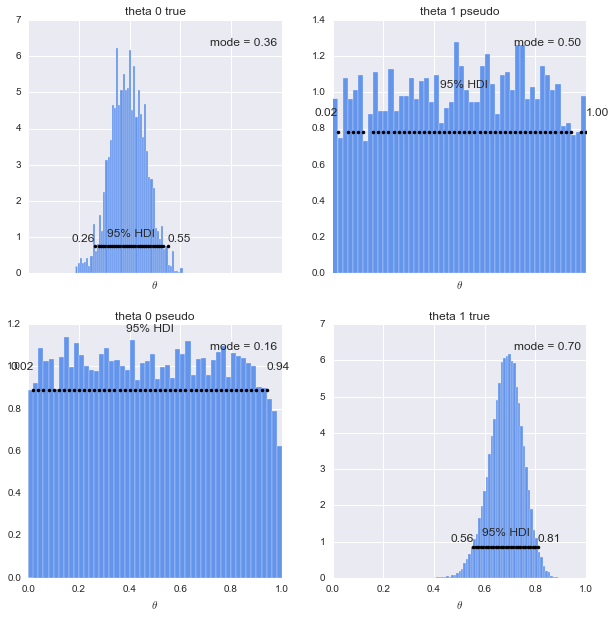

In [108]:
f, axs = plt.subplots(2,2,figsize=(10,10), sharex=True)
plotPost(theta0_true, ax=axs[0,0], title='theta 0 true')
plotPost(theta0_pseu, ax=axs[1,0], title='theta 0 pseudo')

plotPost(theta1_pseu, ax=axs[0,1], title='theta 1 pseudo')
plotPost(theta1_true, ax=axs[1,1], title='theta 1 true')


In [34]:
model0_mask.sum() / (model1_mask.sum() + model0_mask.sum())

0.080460000000000004